# Exploratory data analysis

## 1. Dataset description

1) Global COVID-19 datasets

- The two COVID-19 datasets, [the global confirmed dataset](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv) and [the global death dataset](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv), are from the [data repository](https://github.com/CSSEGISandData/COVID-19) for the 2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE). The dataset is updated every day starting from January 22nd, 2020.

- Both datasets contain columns of location information (`Province/State`, `Country/Region`, `Lat`, and `Long`) or daily accumulated numbers of confirmed or deaths in the corresponding location, starting from `1/22/20` to present.

- As stated in the dataset repository, "Australia, Canada and China are reported at the province/state level. Dependencies of the Netherlands, the UK, France and Denmark are listed under the province/state level. The US and other countries are at the country level."

- The datasets combine data from multiple sources and may contain mistakes.



## 2. Load the dataset

In [52]:
library(MASS)
library(mice)
library(resample)

library(testthat)
library(rjson)
library(httr)
library(jsonlite)

library(plotly)
library(htmlwidgets)
library(repr)
library(cowplot)
library(tidyverse)


Warning message:
"package 'httr' was built under R version 3.6.3"

Attaching package: 'httr'


The following object is masked from 'package:plotly':

    config



Attaching package: 'jsonlite'


The following object is masked from 'package:purrr':

    flatten


The following objects are masked from 'package:rjson':

    fromJSON, toJSON




In [2]:
# get the most recent global COVID-19 confirmed and deaths datasets
url <- "https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series"
covid19_confirmed <- read_csv(paste(url, "/time_series_covid19_confirmed_global.csv?raw=true", sep = ""))
covid19_death <- read_csv(paste(url, "/time_series_covid19_deaths_global.csv?raw=true", sep = ""))

Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)

See spec(...) for full column specifications.



In [3]:
head(covid19_confirmed)

Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469
NA,Albania,41.1533,20.1683,0,0,0,0,0,0,...,663,678,712,726,736,750,766,773,782,789
NA,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295
NA,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,723,731,738,738,743,743,743,745,745,747
NA,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,25,25,25,26,27,27,27,27,30,35
NA,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,...,24,24,24,24,24,24,24,24,25,25


In [318]:
res <- GET("https://www.alphavantage.co/query",
           query = list(`function` = "FX_DAILY",
                        from_symbol = "CAD",
                        to_symbol = "USD",
                        outputsize = "full",
                        apikey = Sys.getenv("ALPHA_API")))
data <- fromJSON(rawToChar(res$content))
data_raw <- enframe(unlist(data["Time Series FX (Daily)"]))
cad_to_usd <- data_raw %>%
    mutate(label = rep(c("open", "high", "low", "close"), dim(data_raw)[1]/4),
           date = str_match(name, "[0-9-]+") %>% lubridate::ymd(),
           value = as.double(value)) %>%
    select(date, label, value)

str(cad_to_usd)
summary(cad_to_usd)

Classes 'tbl_df', 'tbl' and 'data.frame':	5684 obs. of  3 variables:
 $ date : Date, format: "2020-05-04" "2020-05-04" ...
 $ label: chr  "open" "high" "low" "close" ...
 $ value: num  0.707 0.709 0.706 0.707 0.716 ...


      date               label               value       
 Min.   :2014-11-24   Length:5684        Min.   :0.6802  
 1st Qu.:2016-04-04   Class :character   1st Qu.:0.7505  
 Median :2017-08-14   Mode  :character   Median :0.7616  
 Mean   :2017-08-13                      Mean   :0.7668  
 3rd Qu.:2018-12-24                      3rd Qu.:0.7805  
 Max.   :2020-05-04                      Max.   :0.8907  

In [349]:
pop <- read_csv("../data/raw_data/API_SP.POP.TOTL_DS2_en_csv_v2_988606.csv", skip = 4)

pop <- pop %>%
    filter(`Country Name` %in% c("United States", "Canada")) %>%
    pull(`2018`)

Warning message:
"Missing column names filled in: 'X65' [65]"
Parsed with column specification:
cols(
  .default = col_double(),
  `Country Name` = col_character(),
  `Country Code` = col_character(),
  `Indicator Name` = col_character(),
  `Indicator Code` = col_character(),
  `2019` = col_logical(),
  X65 = col_logical()
)

See spec(...) for full column specifications.



In [265]:
res <- GET("https://query1.finance.yahoo.com/v7/finance/download/CL=F",
           query = list(period1 = as.integer(as.POSIXct(as.Date("2018/1/1"))),
                        period2 = as.integer(as.POSIXct(Sys.Date())),
                        interval = "1d",
                        events = "history"))


In [266]:
oil_df <- read_csv(content(res, "text"))
colnames(oil_df) <- c("date", "open", "high", "low", "close", "adj_close", "volume")
crude_oil <- oil_df %>%
    filter(open != "null") %>%
    mutate_all(as.double) 
crude_oil$date <- oil_df %>%
    filter(open != "null") %>%
    pull(date)

head(crude_oil)

No encoding supplied: defaulting to UTF-8.



date,open,high,low,close,adj_close,volume
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-01-02,60.20,60.74,60.10,60.37,60.37,464478
2018-01-03,60.39,61.97,60.28,61.63,61.63,510313
2018-01-04,61.96,62.21,61.59,62.01,62.01,673859
2018-01-05,61.90,62.04,61.09,61.44,61.44,654363
2018-01-08,61.61,61.97,61.34,61.73,61.73,563036
2018-01-09,61.92,63.48,61.80,62.96,62.96,616474


In [320]:
data_cp <- tibble(date = seq(as.Date("2018-01-01"), Sys.Date(), "day")) %>%
    merge(cad_to_usd %>% filter(label == "close") %>% select(date, value), 
          by = "date", all.x = TRUE) %>%
    merge(crude_oil %>% select(date, close), 
          by = "date", all.x = TRUE)
colnames(data_cp) = c("date", "cad_to_usd", "crude_oil")
dim(data_cp)
head(data_cp)

[1] 854   3

date,cad_to_usd,crude_oil
<date>,<dbl>,<dbl>
2018-01-01,0.7964,NA
2018-01-02,0.7986,60.37
2018-01-03,0.7972,61.63
2018-01-04,0.8004,62.01
2018-01-05,0.8059,61.44
2018-01-06,NA,NA


## 3. Explore the dataset

In [168]:
print("Check the dimension of the global confirmed dataset:")
dim(covid19_confirmed)
print(paste("The most recent data in the global confirmed dataset is from", 
      colnames(covid19_confirmed)[length(covid19_confirmed)]))

print("Check the dimension of the global deaths dataset:")
dim(covid19_death)
print(paste("The most recent data in the global deaths dataset is from", 
            colnames(covid19_death)[length(covid19_death)]))

print(paste("There are", length(unique(covid19_confirmed$`Country/Region`)), 
            "unqiue countries or regions in the global COVID-19 datasets"))


[1] "Check the dimension of the global confirmed dataset:"


[1] 266 106

[1] "The most recent data in the global confirmed dataset is from 5/2/20"
[1] "Check the dimension of the global deaths dataset:"


[1] 266 106

[1] "The most recent data in the global deaths dataset is from 5/2/20"
[1] "There are 187 unqiue countries or regions in the global COVID-19 datasets"


In [169]:
test_that("Column names of covid19_confirmed and covid19_death should be the same.",
          {expect_true(all(colnames(covid19_confirmed) == colnames(covid19_death)))
          })

test_that("The country column of covid19_confirmed and covid19_death should be the same.",
          {expect_true(all(covid19_confirmed[2] == covid19_death[2]))
          })

test_that("The last column of covid19_confirmed should not have missing values.",
          {expect_true(all(!is.na(covid19_confirmed[length(covid19_confirmed)])))
          })

test_that("The last column of covid19_death should not have missing values.",
          {expect_true(all(!is.na(covid19_death[length(covid19_death)])))
          })

## 4. Initial thoughts


## 5. Wrangling

In [ ]:
#' Extracts COVID-19 confirmed and death numbers
#' of a given country from the global datasets
#'
#' @param country the country name
#'
#' @return dataframe
get_country_data <- function(country) {
    df <- covid19_confirmed %>%
        filter(`Country/Region` == country) %>%
        select(-`Country/Region`, -Lat, -Long, -`Province/State`) %>%
        gather("date", "confirmed") %>%
        mutate(date = lubridate::mdy(date)) %>%
        group_by(date) %>%
        summarize(confirmed = sum(confirmed))

    death <- covid19_death %>%
        filter(`Country/Region` == country) %>%
        select(-`Country/Region`, -Lat, -Long, -`Province/State`) %>%
        gather("date", "death") %>%
        mutate(date = lubridate::mdy(date)) %>%
        group_by(date) %>%
        summarize(death = sum(death))
    
    df$death <- death$death
    df
}

In [375]:
us_data <- get_country_data("US")
ca_data <- get_country_data("Canada")

In [ ]:
summary(us_data)
summary(ca_data)

In [376]:
us_data$country = 'US'
ca_data$country = 'Canada'
cb_data <- rbind(us_data, ca_data)

In [377]:
data_cp$cad_to_usd[1] <- cad_to_usd %>%
    filter(date == as.Date("2019-1-2"),
           label == "open") %>%
    pull(value)

In [322]:
# data imputation with last observation carried over
data_cp <- data_cp %>% 
    zoo::na.locf()

In [379]:
data_2020 <- data_cp %>%
    filter(date >= as.Date("2020-1-22")) %>%
    merge(us_data, by = "date", x.all =TRUE) %>%
    merge(ca_data, by = "date", x.all =TRUE) %>%
    mutate(us_rate = confirmed.x/pop[1],
           ca_rate = confirmed.y/pop[2]) %>%
    select(date, cad_to_usd, crude_oil, us_rate, ca_rate)


## 6. Research questions



## 7. Data Analysis & Visualizations

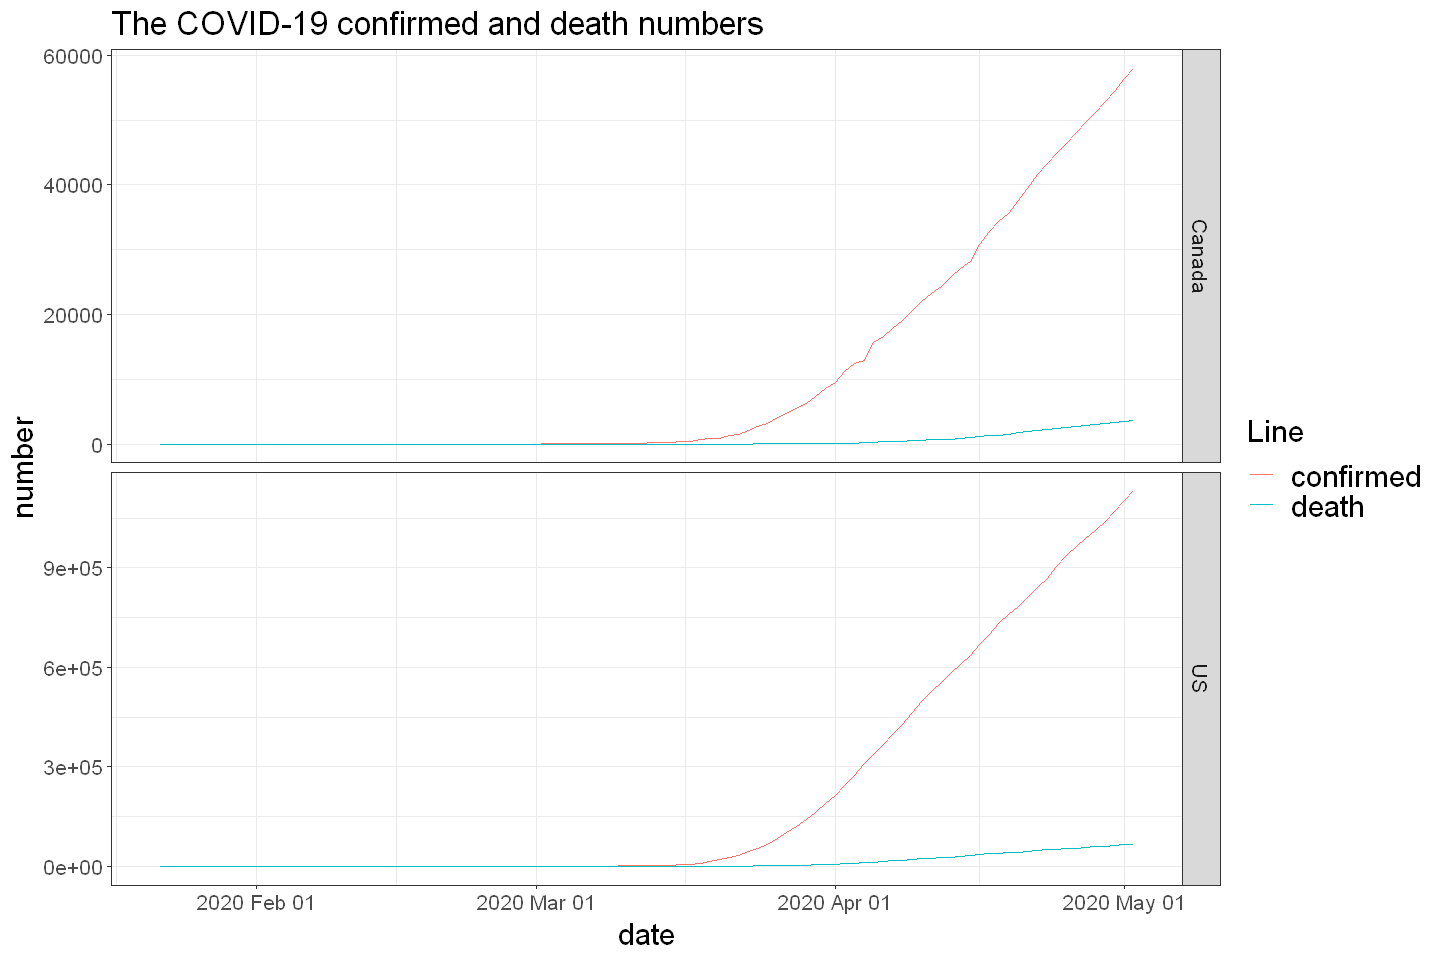

In [51]:
t <- theme(plot.title = element_text(size = 20),
           axis.title = element_text(size = 18),
           text = element_text(size = 16),
           legend.title = element_text(size = 18),
           legend.text = element_text(size = 18),
           strip.text.x = element_text(size = 18))

options(repr.plot.width = 12, repr.plot.height = 8)

cb_data %>%
    gather("term", "number", - date, - country) %>%
    ggplot(aes(date, number, color = term)) +
    geom_line() +
    scale_x_date(date_labels = "%Y %b %d") +
    facet_grid(rows = vars(country), scales = "free") +
    theme_bw() +
    labs(title = "The COVID-19 confirmed and death numbers",
         color = "Line") + t

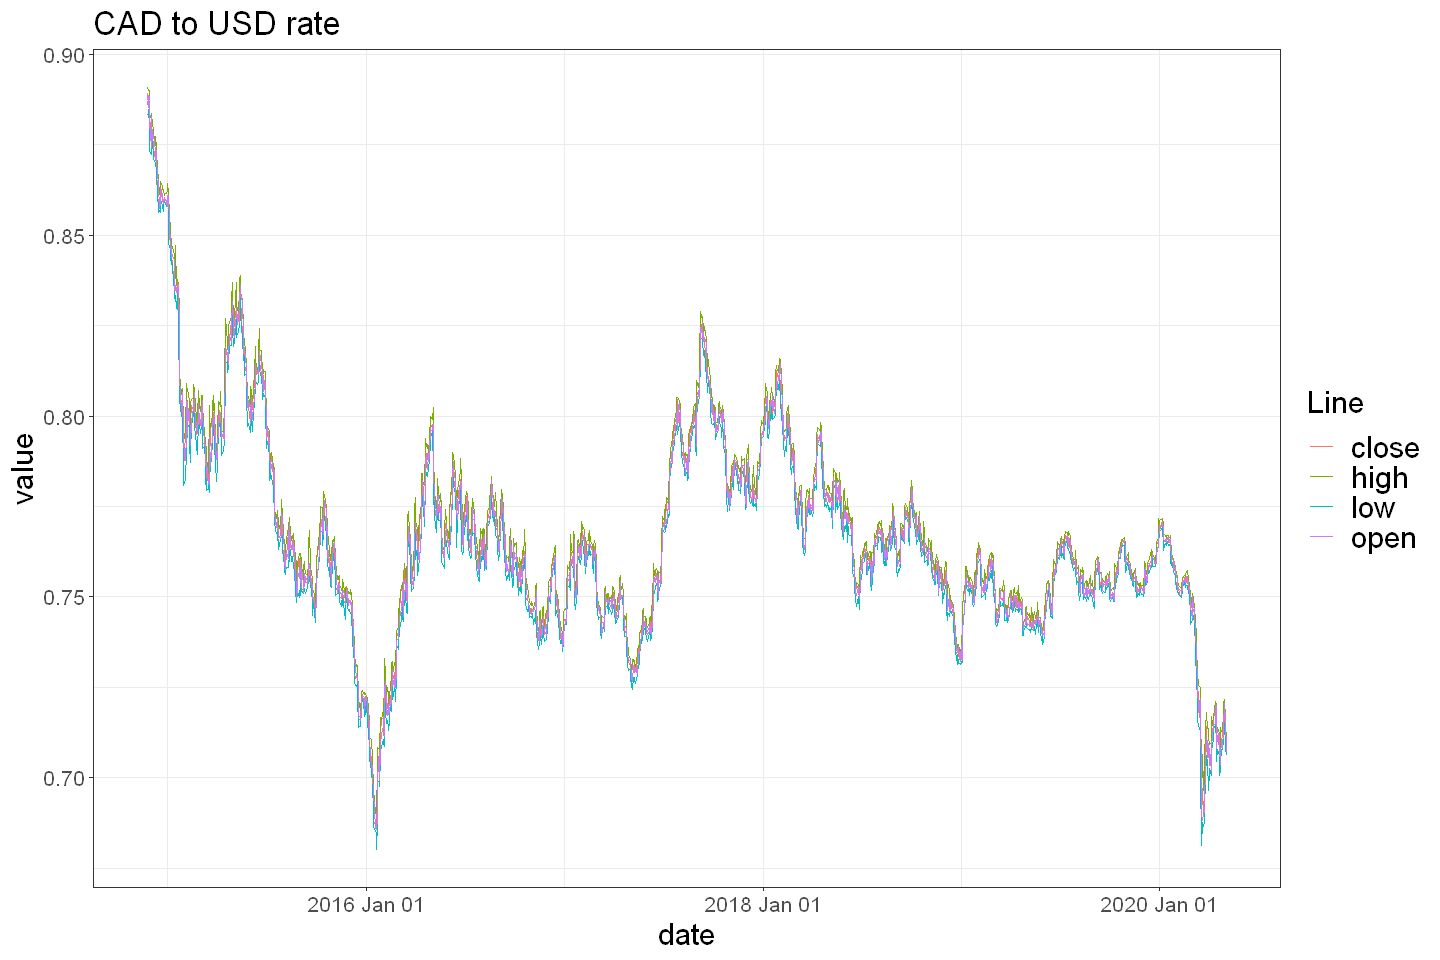

In [324]:
cad_to_usd %>%
    ggplot(aes(date, value, color = label)) +
    geom_line() +
    scale_x_date(date_labels = "%Y %b %d") +
    theme_bw() +
    labs(title = "CAD to USD rate",
         color = "Line") + t    

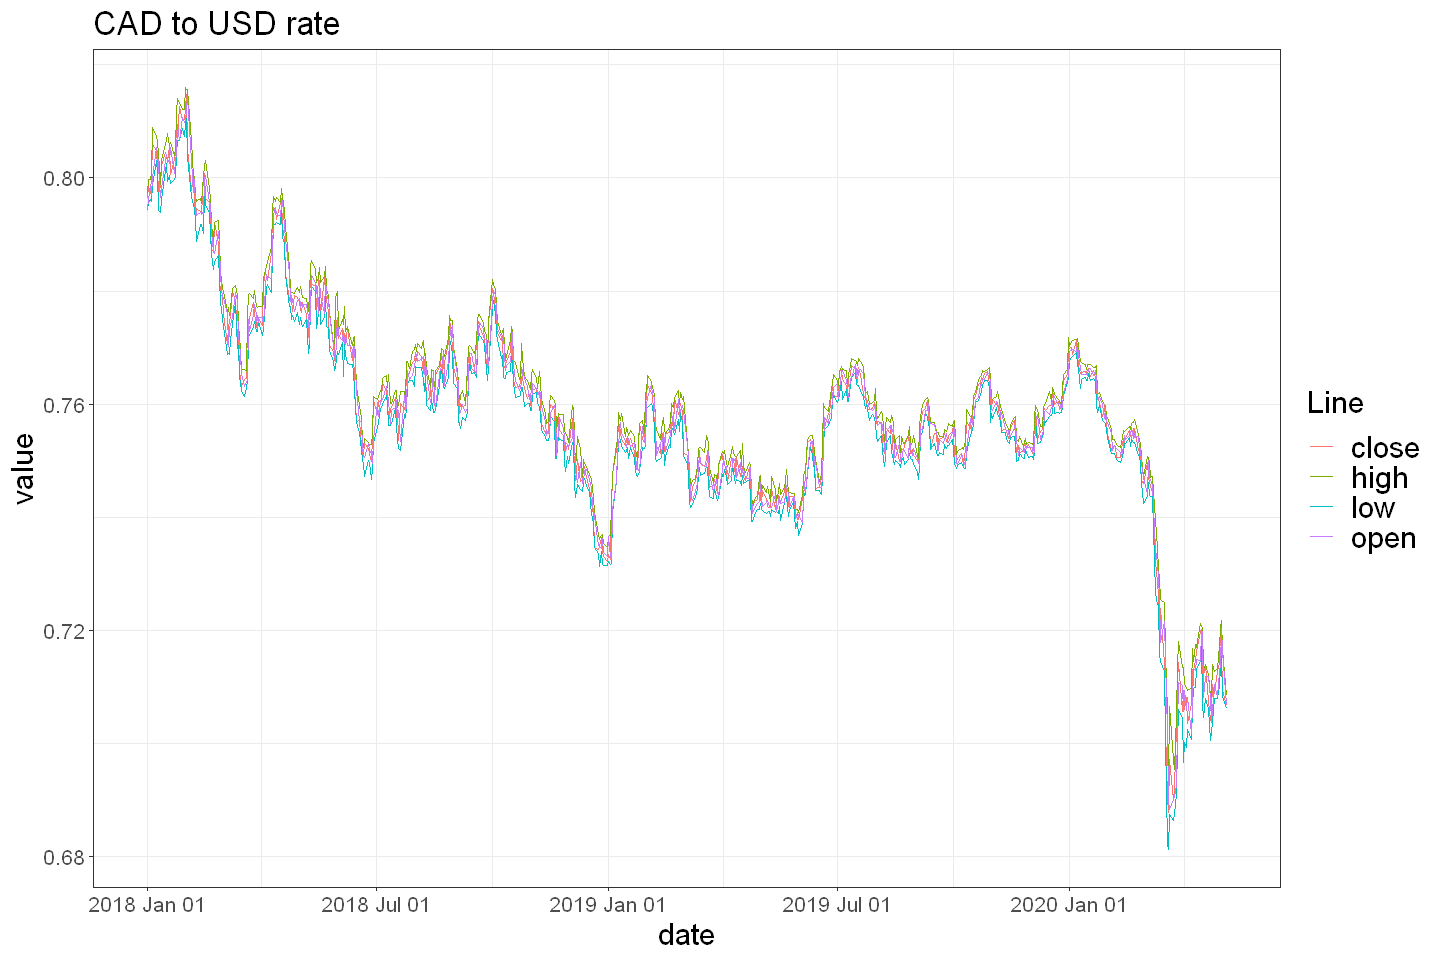

In [404]:
cad_to_usd %>%
    filter(lubridate::year(date) >= 2018) %>%
    ggplot(aes(date, value, color = label)) +
    geom_line() +
    scale_x_date(date_labels = "%Y %b %d") +
    theme_bw() +
    labs(title = "CAD to USD rate",
         color = "Line") + t    

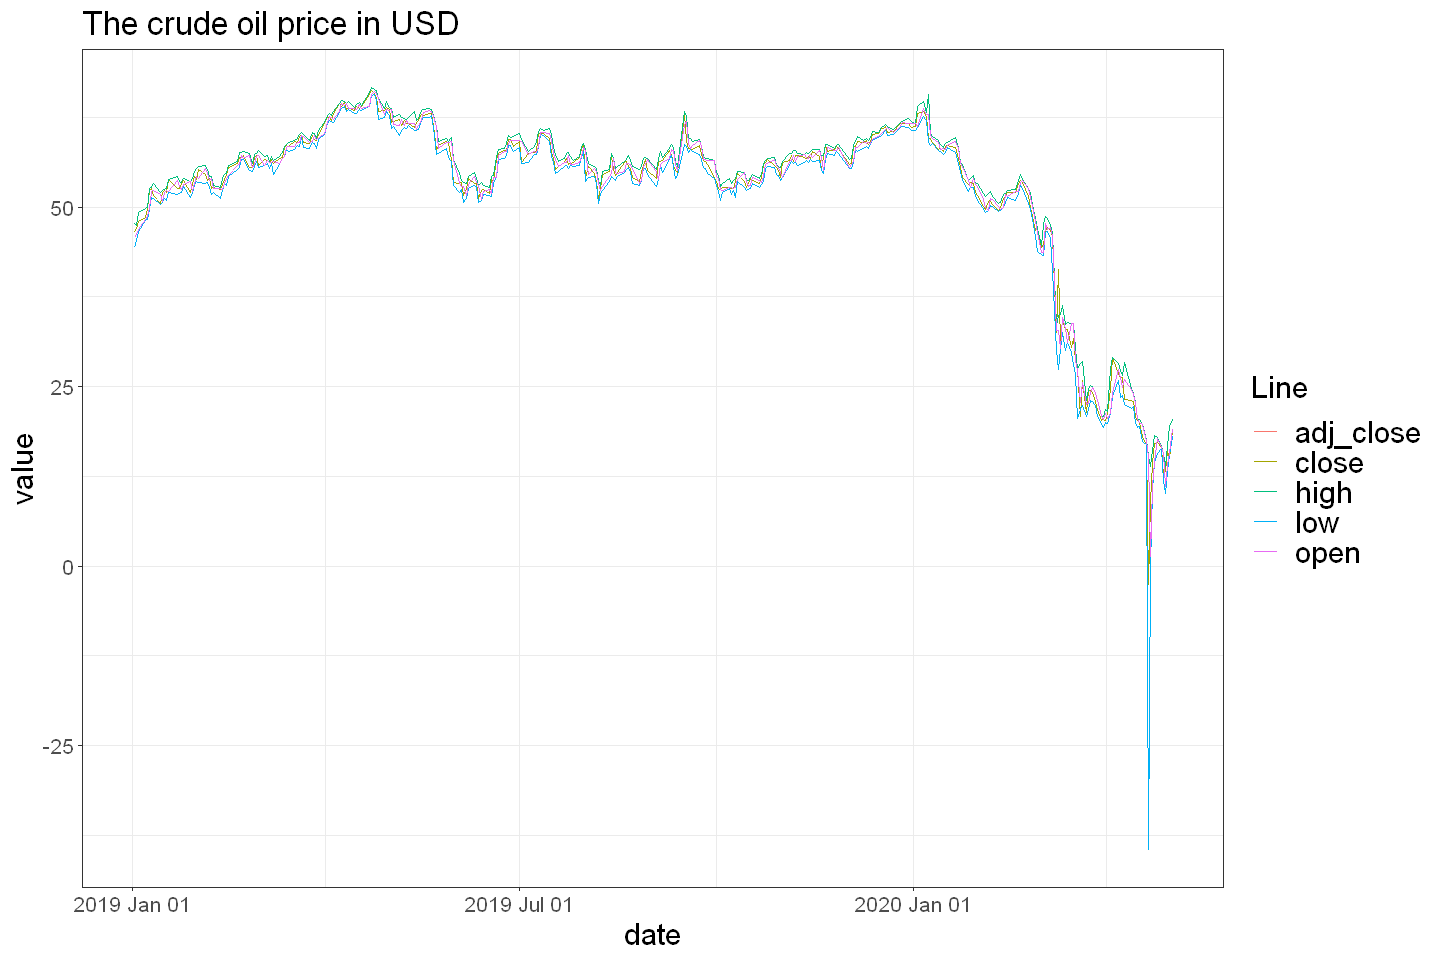

In [405]:
crud_oil %>%
    gather("term", "value", - date, - volume) %>%
    ggplot(aes(date, value, color = term)) +
    geom_line() +
    scale_x_date(date_labels = "%Y %b %d") +
    theme_bw() +
    labs(title = "The crude oil price in USD",
         color = "Line") + t   

In [385]:
cad_to_usd_ts <- ts(data_cp$cad_to_usd, 
                    start = c(2018, as.numeric(format(data_cp$date[1], "%j"))),
                    frequency = 365)
crude_oil_ts <- ts(data_cp$crude_oil, 
                    start = c(2018, as.numeric(format(data_cp$date[1], "%j"))),
                    frequency = 365)

cad_to_usd_log_ts <- ts(log(data_cp$cad_to_usd), 
                    start = c(2018, as.numeric(format(data_cp$date[1], "%j"))),
                    frequency = 365)
crude_oil_log_ts <- ts(log(data_cp$crude_oil), 
                    start = c(2018, as.numeric(format(data_cp$date[1], "%j"))),
                    frequency = 365)
cad_to_usd_2020_ts <- ts(data_2020$cad_to_usd, 
                    start = c(2020, as.numeric(format(data_2020$date[1], "%j"))),
                    frequency = 365)
crude_oil_2020_ts <- ts(data_2020$crude_oil, 
                    start = c(2020, as.numeric(format(data_2020$date[1], "%j"))),
                    frequency = 365)


Warning message in log(data_cp$crude_oil):
"NaNs produced"


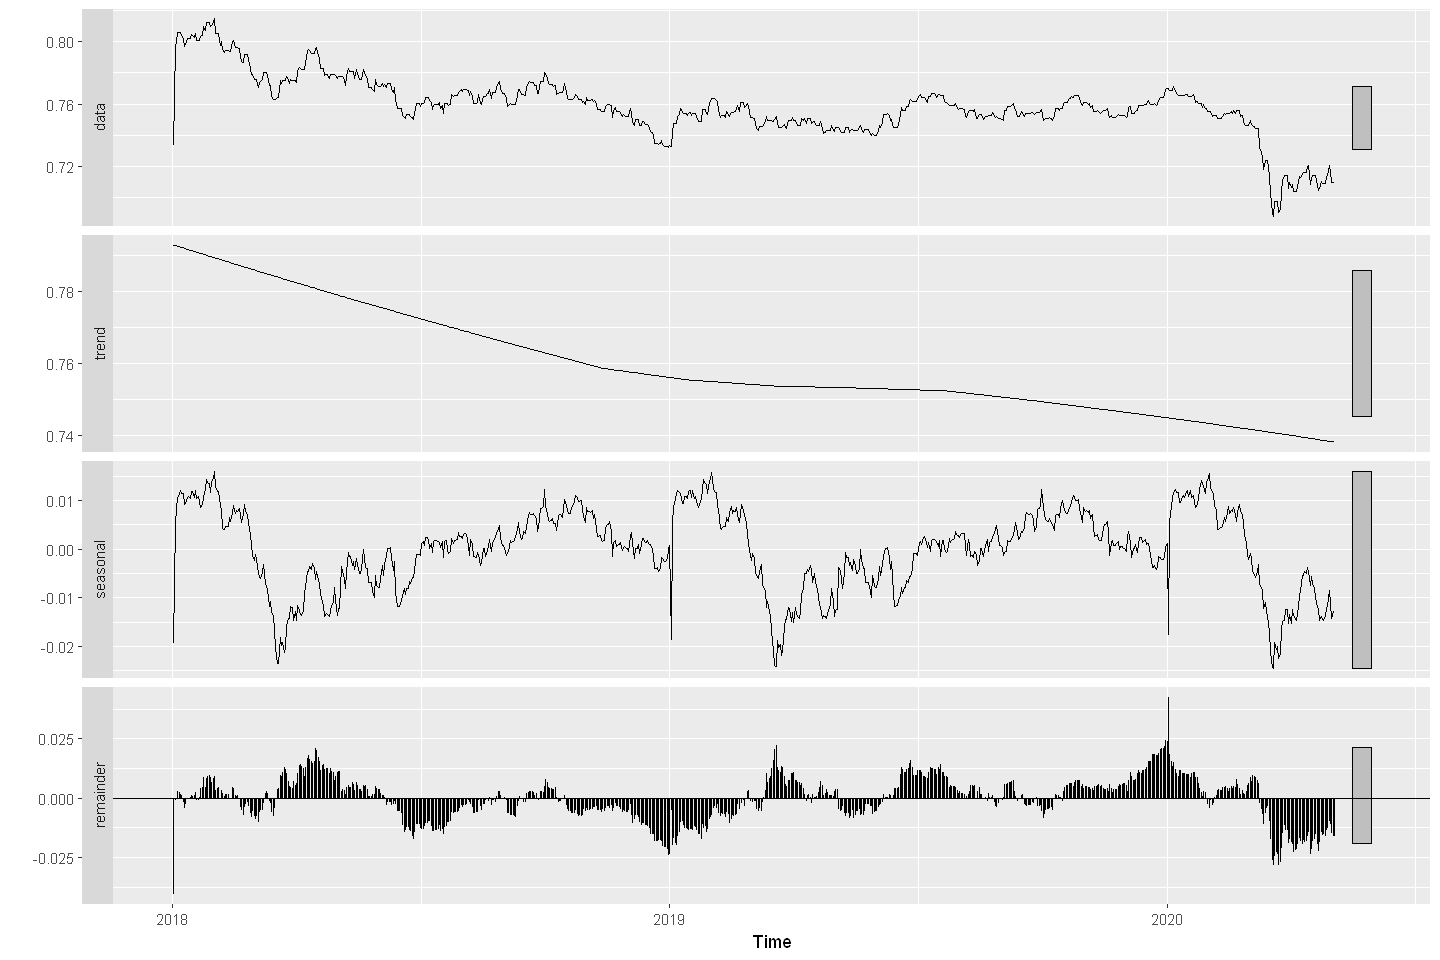

In [407]:
stl(cad_to_usd_ts, s.window = 12) %>% 
  autoplot()

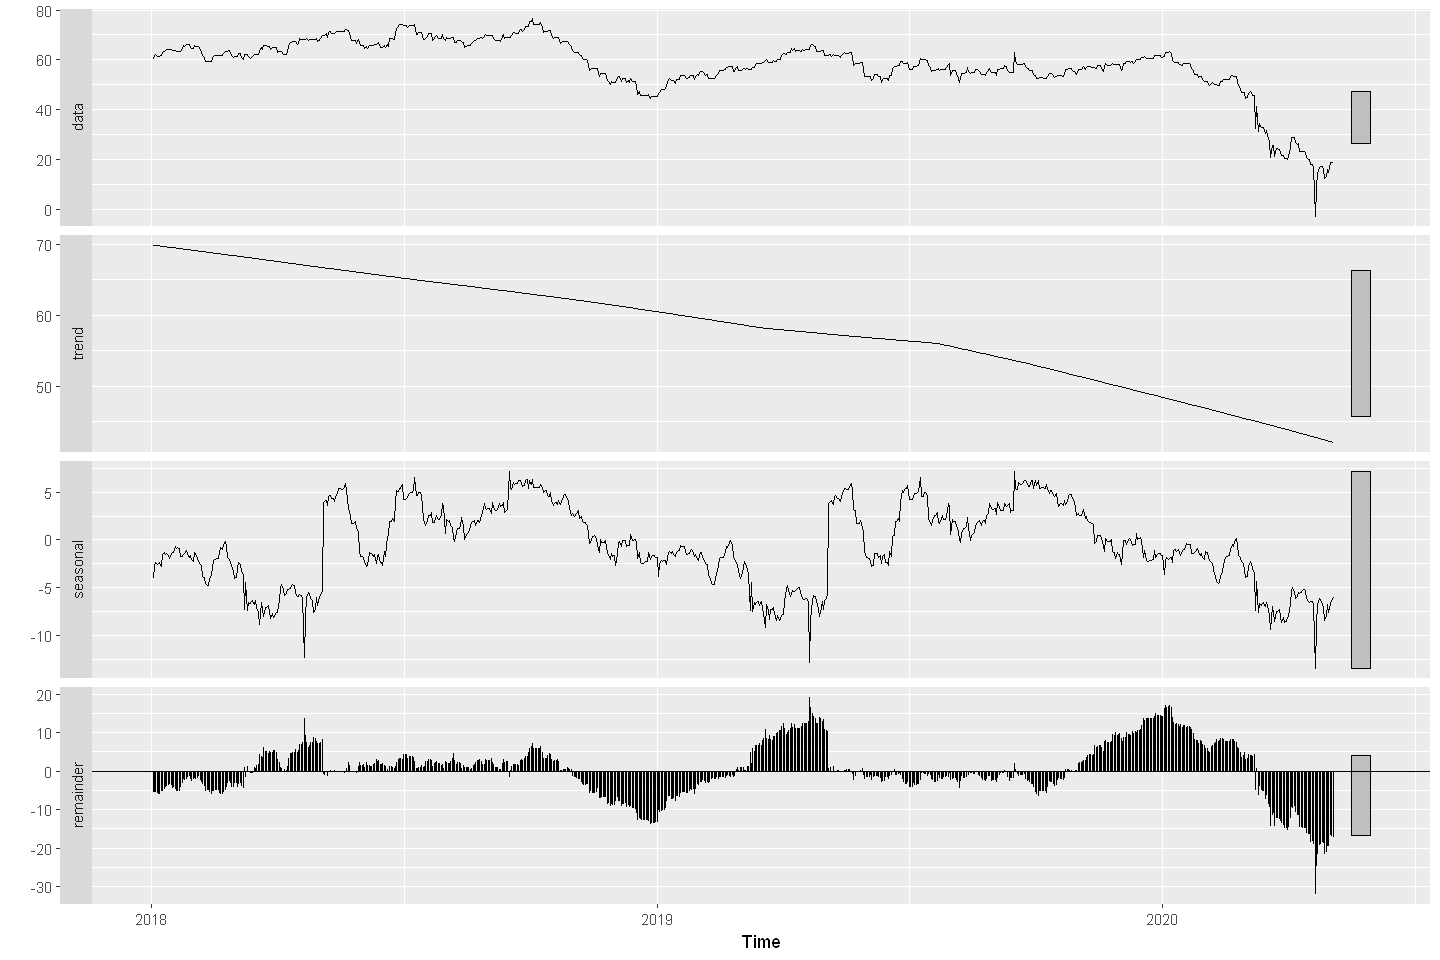

In [408]:
stl(crude_oil_ts, s.window = 12) %>% 
  autoplot()

Warning message:
"attributes are not identical across measure variables;
they will be dropped"


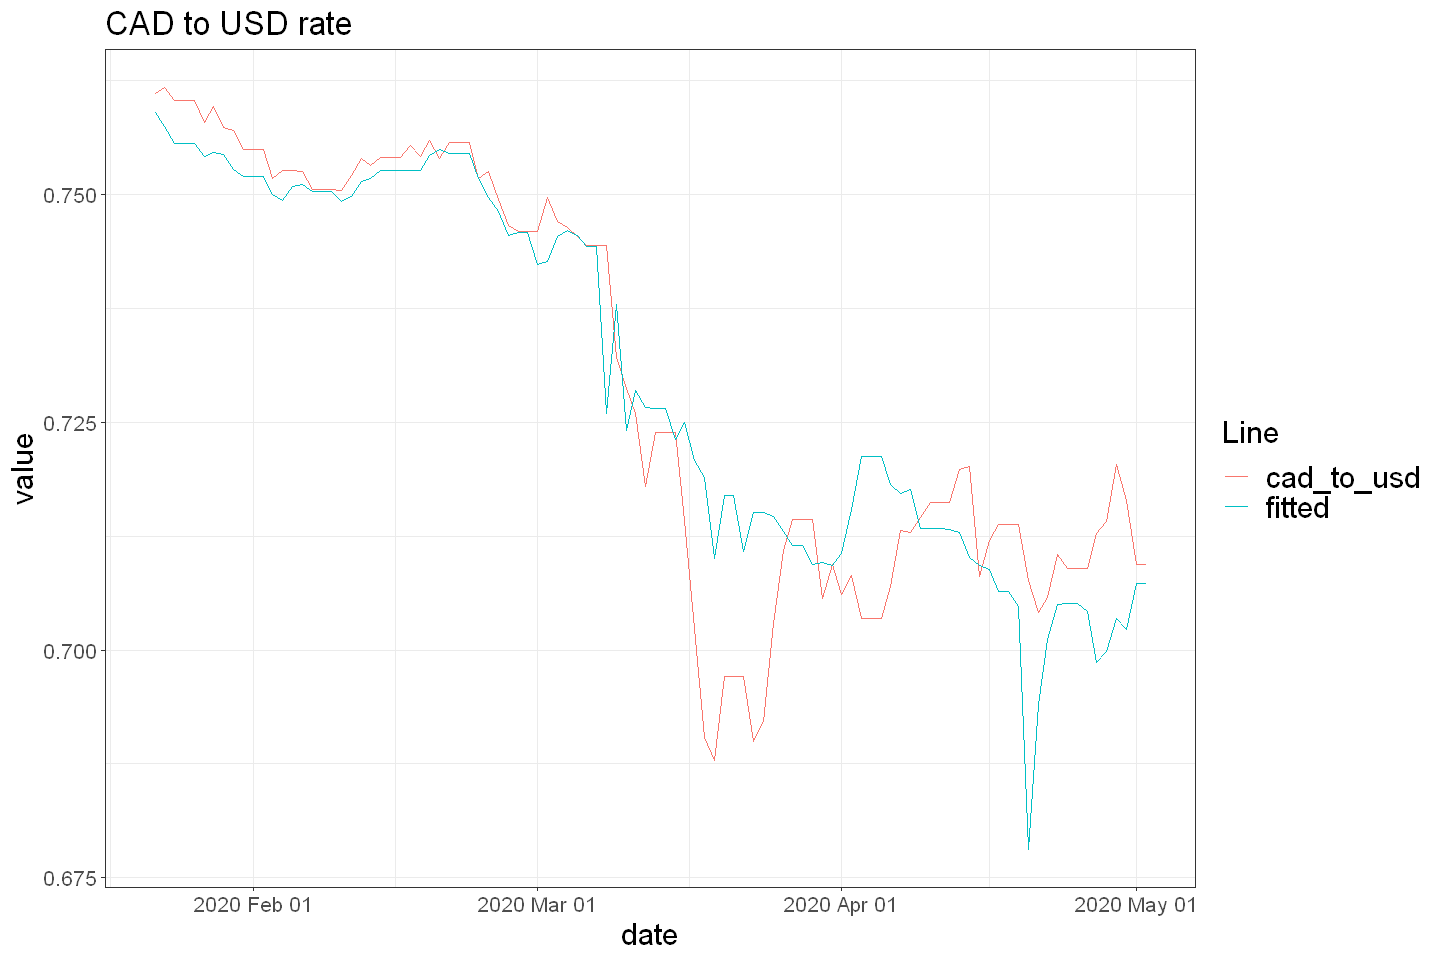

In [400]:
data_2020 %>%
    mutate(fitted = fit$fitted) %>%
    select(date, cad_to_usd, fitted) %>%
    gather("term", "value", - date) %>%
    ggplot(aes(date, value, color = term)) +
    geom_line() +
    scale_x_date(date_labels = "%Y %b %d") +
    theme_bw() +
    labs(title = "CAD to USD rate",
         color = "Line") + t    


Call:
lm(formula = cad_to_usd ~ crude_oil, data = data_2020)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.028533 -0.001144  0.001507  0.003799  0.029482 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 6.817e-01  2.328e-03  292.79   <2e-16 ***
crude_oil   1.364e-03  6.052e-05   22.53   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.009178 on 100 degrees of freedom
Multiple R-squared:  0.8355,	Adjusted R-squared:  0.8338 
F-statistic: 507.8 on 1 and 100 DF,  p-value: < 2.2e-16


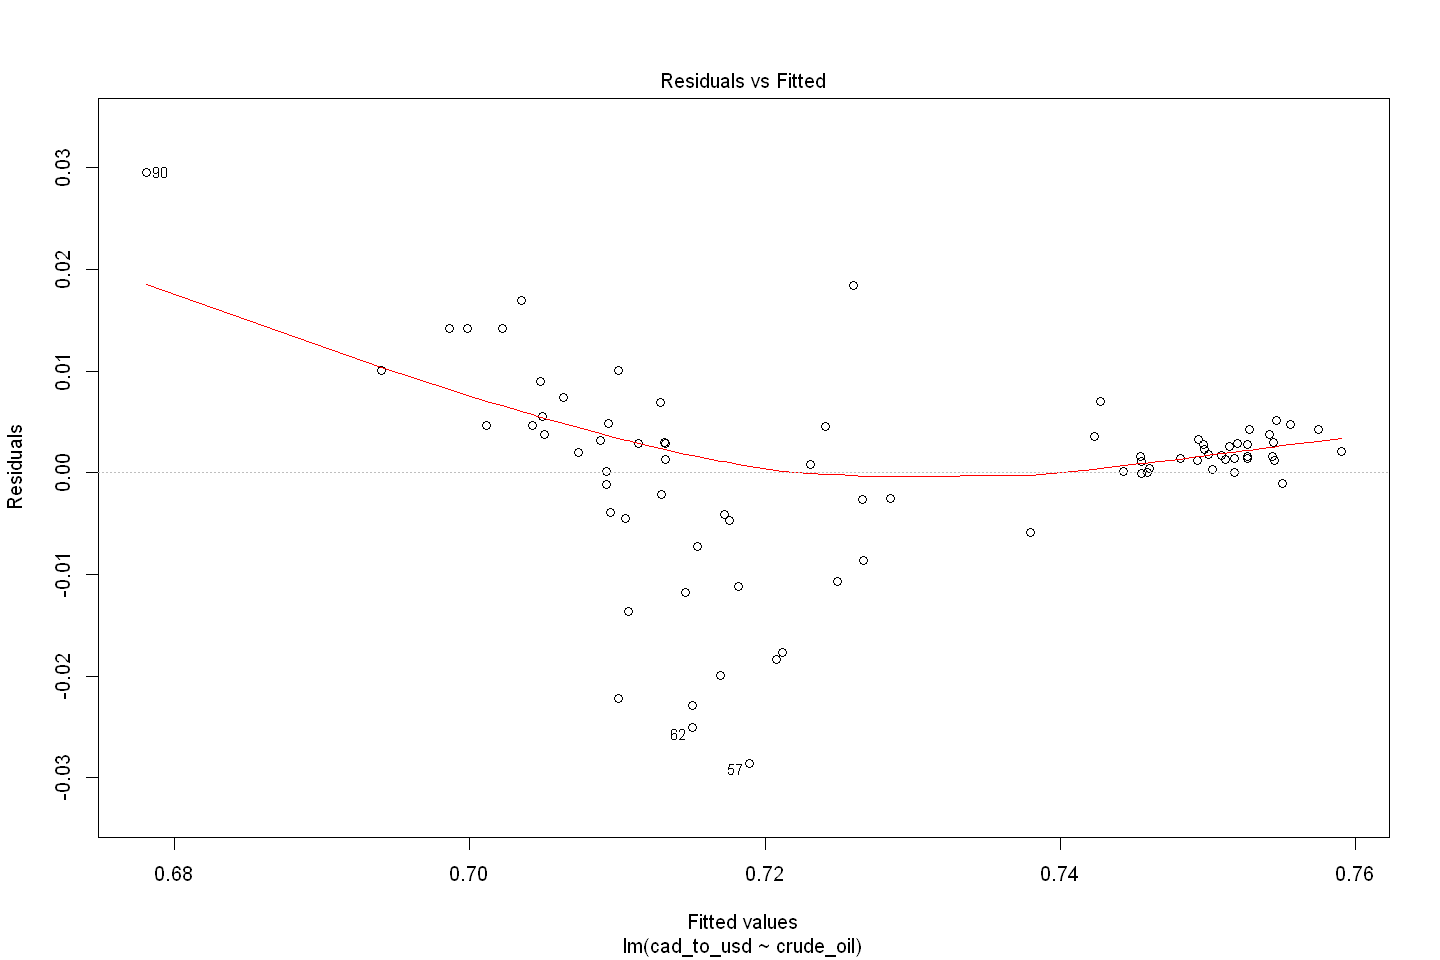

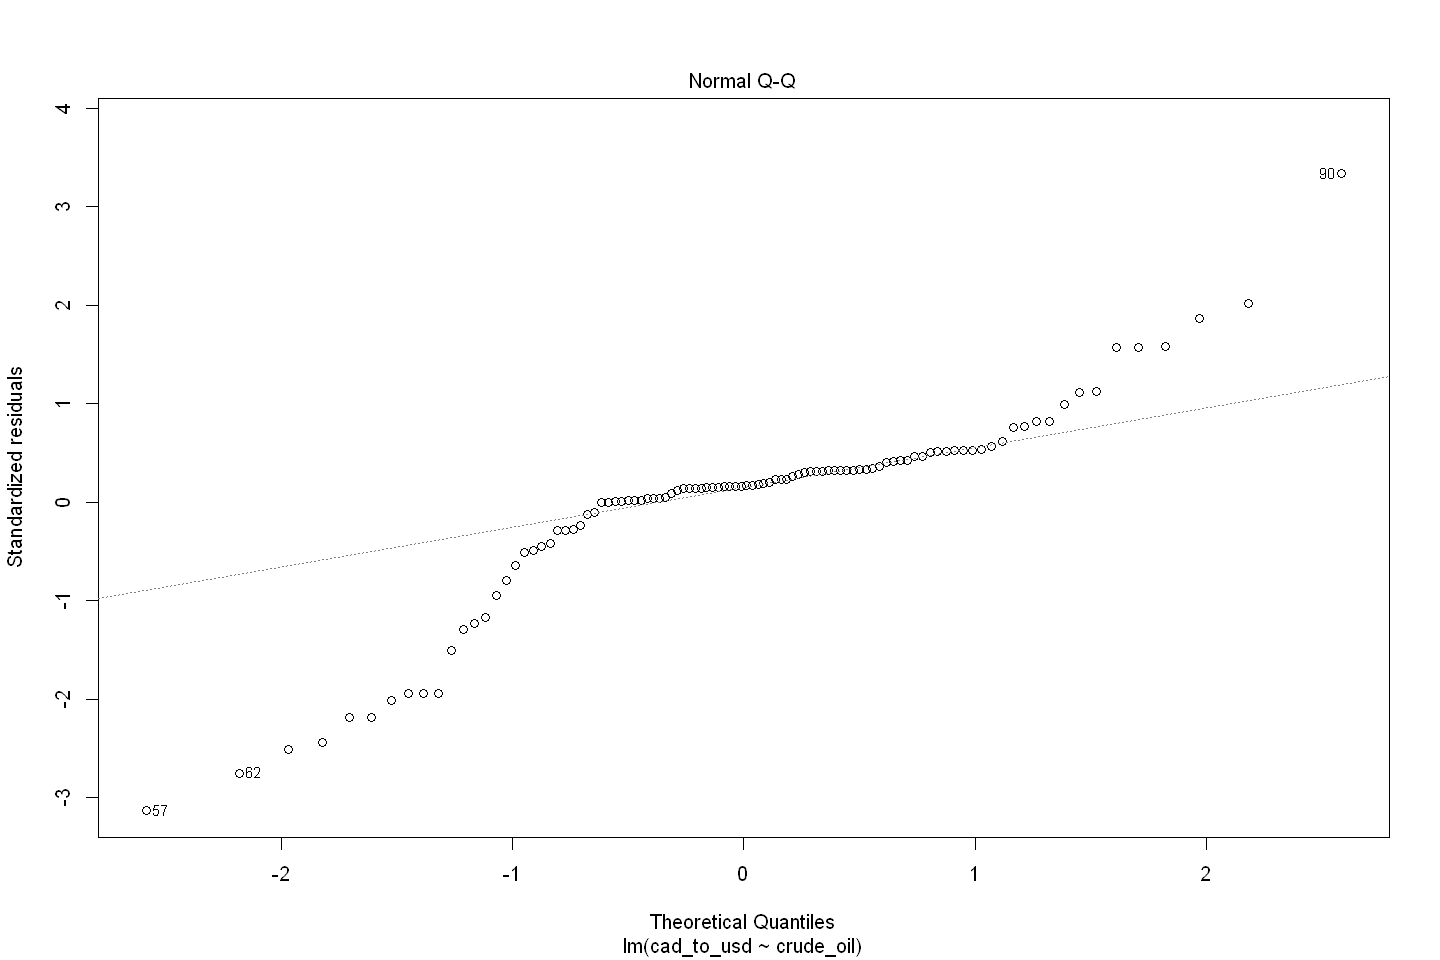

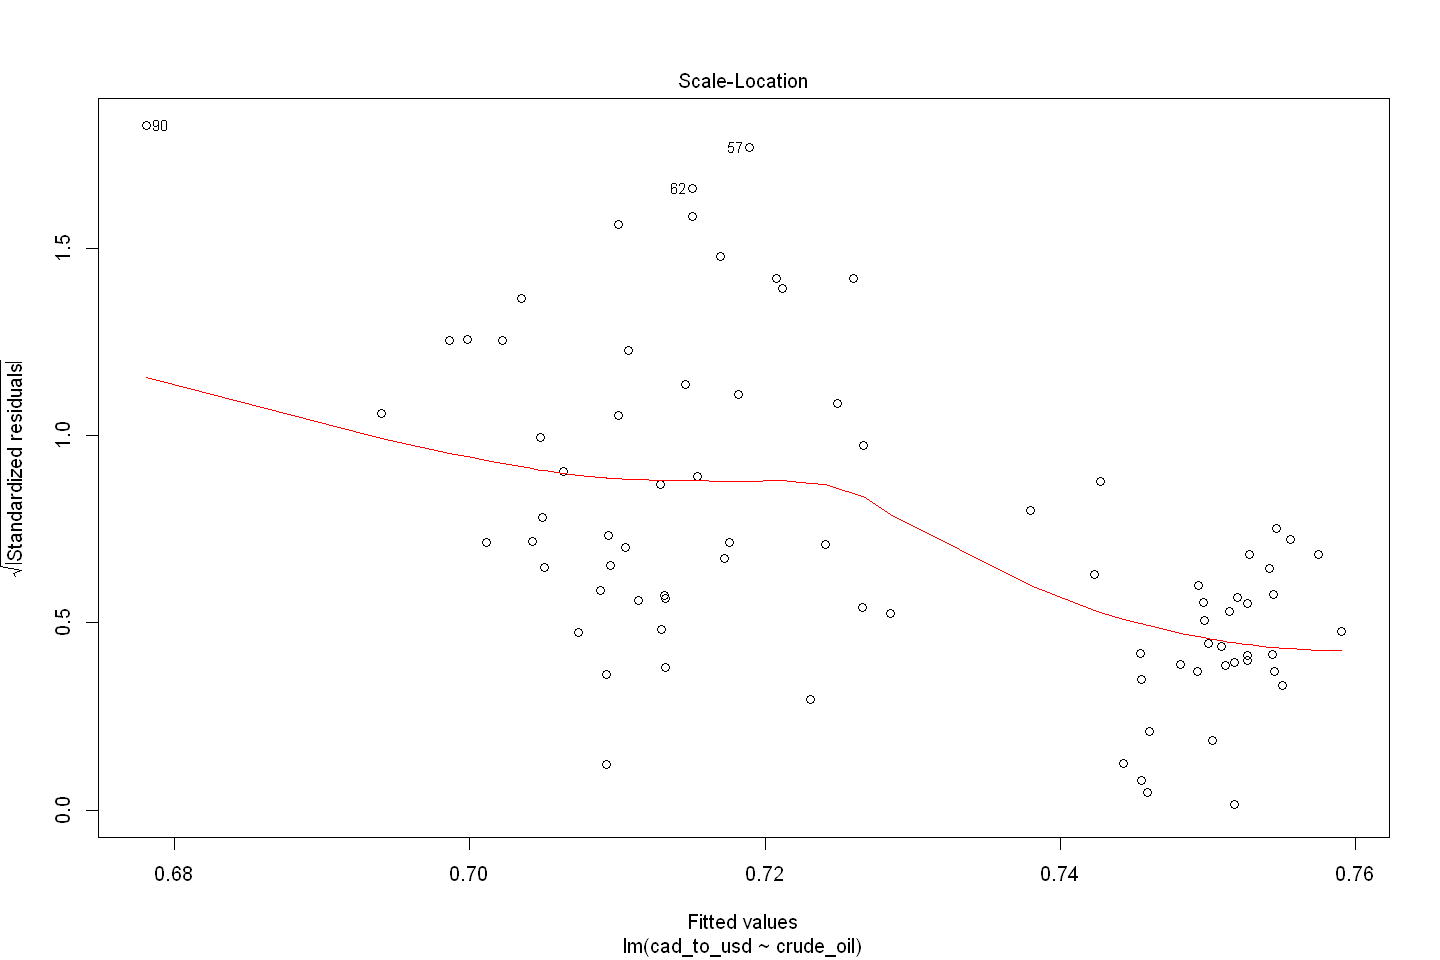

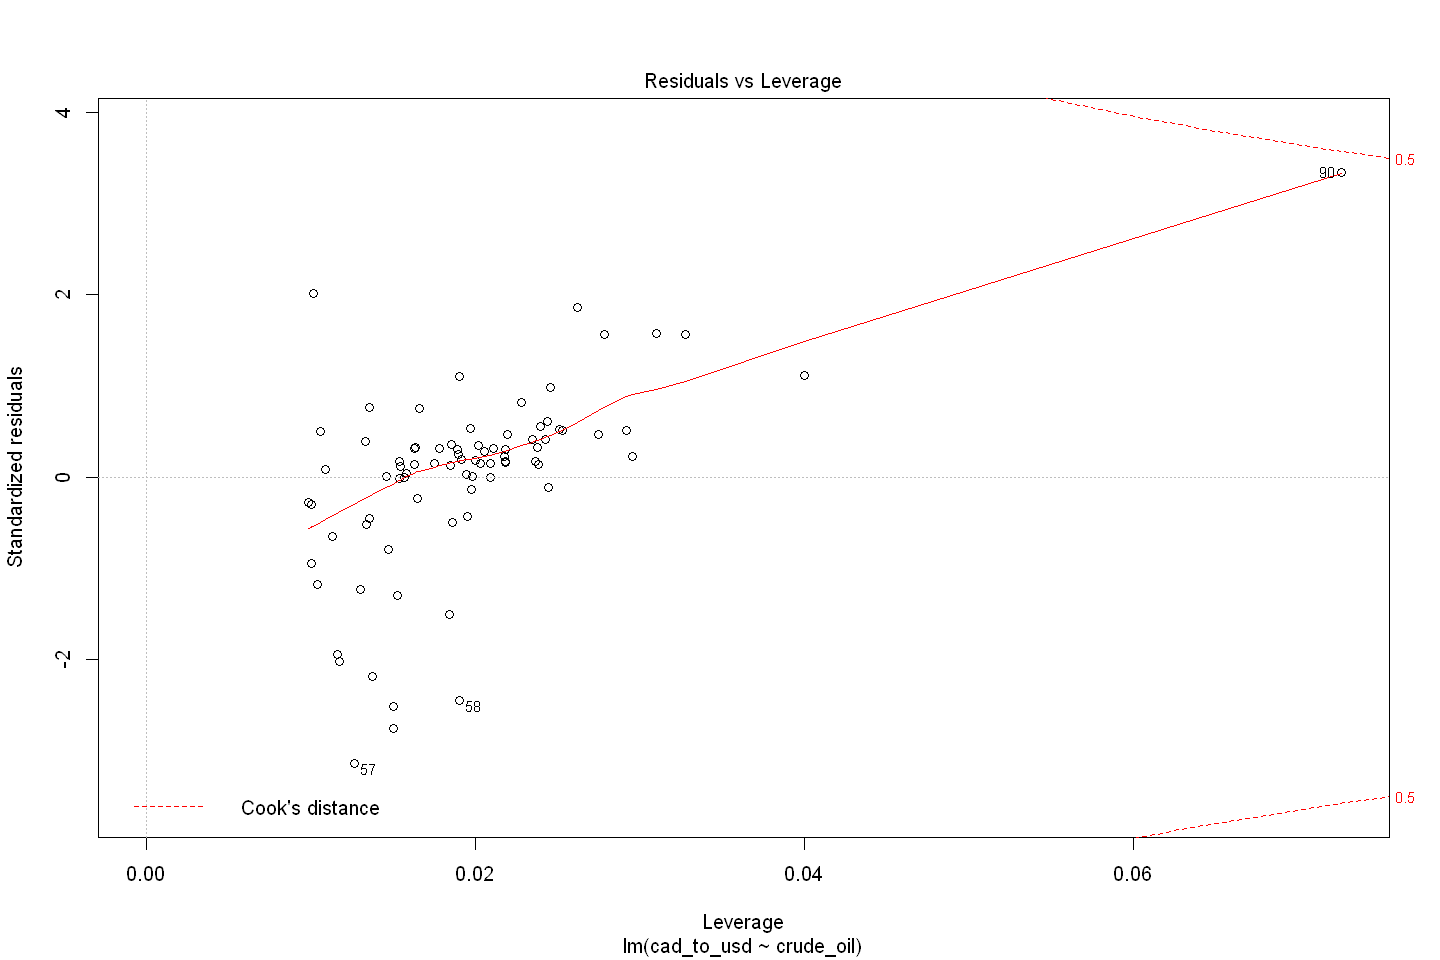

In [399]:
fit <- lm(cad_to_usd ~ crude_oil, data_2020)
summary(fit)
plot(fit)


Call:
lm(formula = cad_to_usd ~ crude_oil, data = data_cp %>% filter(date > 
    as.Date("2019-1-1")))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.030572 -0.003631  0.002125  0.005850  0.019987 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 6.905e-01  1.804e-03   382.9   <2e-16 ***
crude_oil   1.115e-03  3.347e-05    33.3   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.00869 on 486 degrees of freedom
Multiple R-squared:  0.6953,	Adjusted R-squared:  0.6947 
F-statistic:  1109 on 1 and 486 DF,  p-value: < 2.2e-16


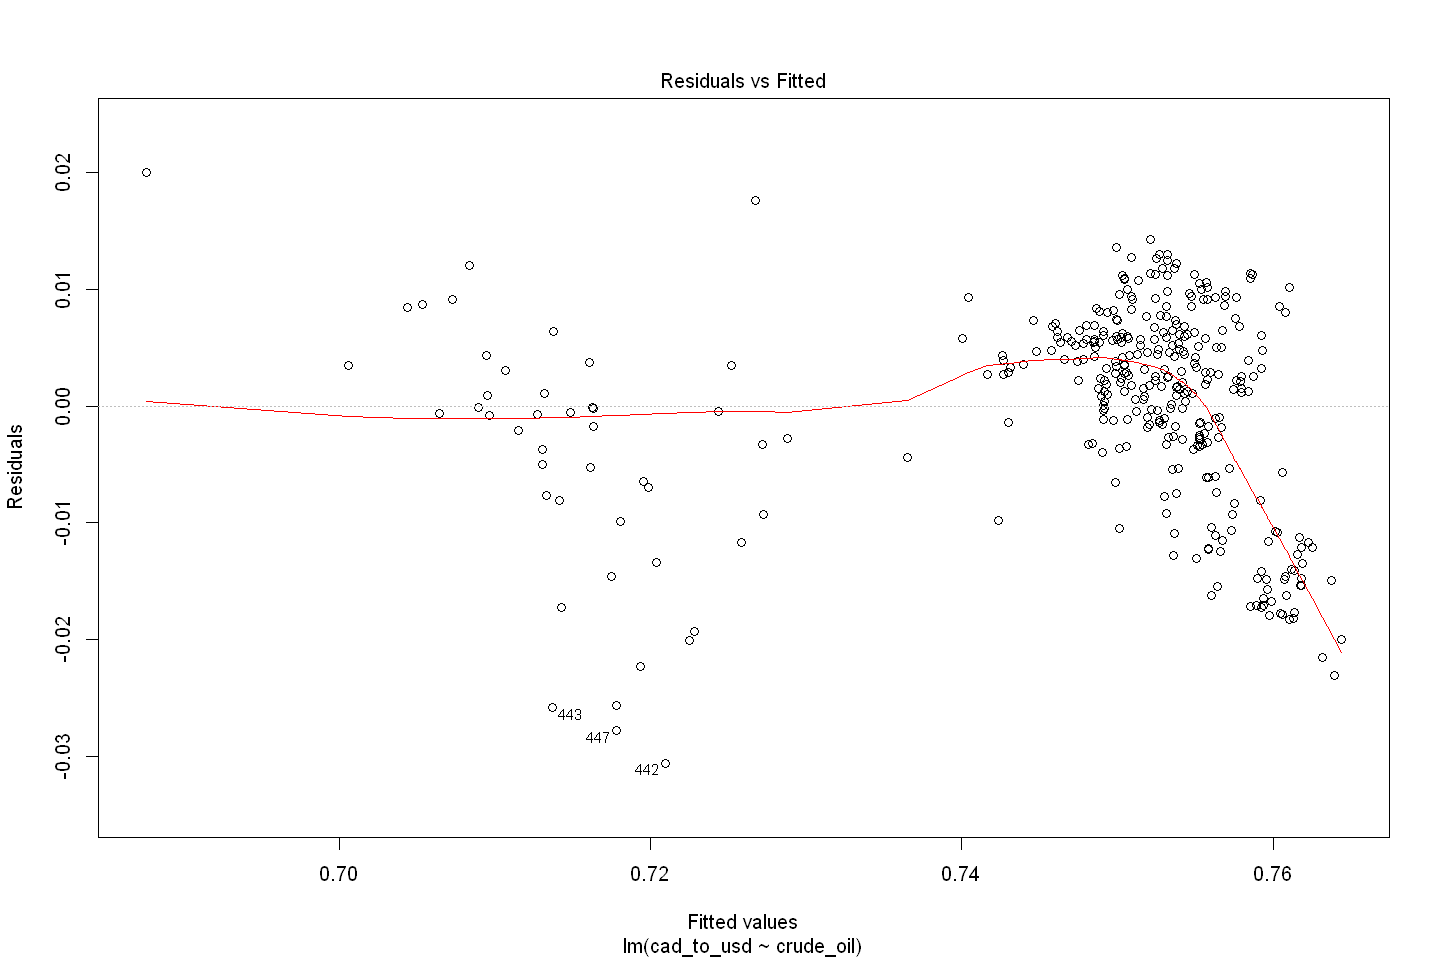

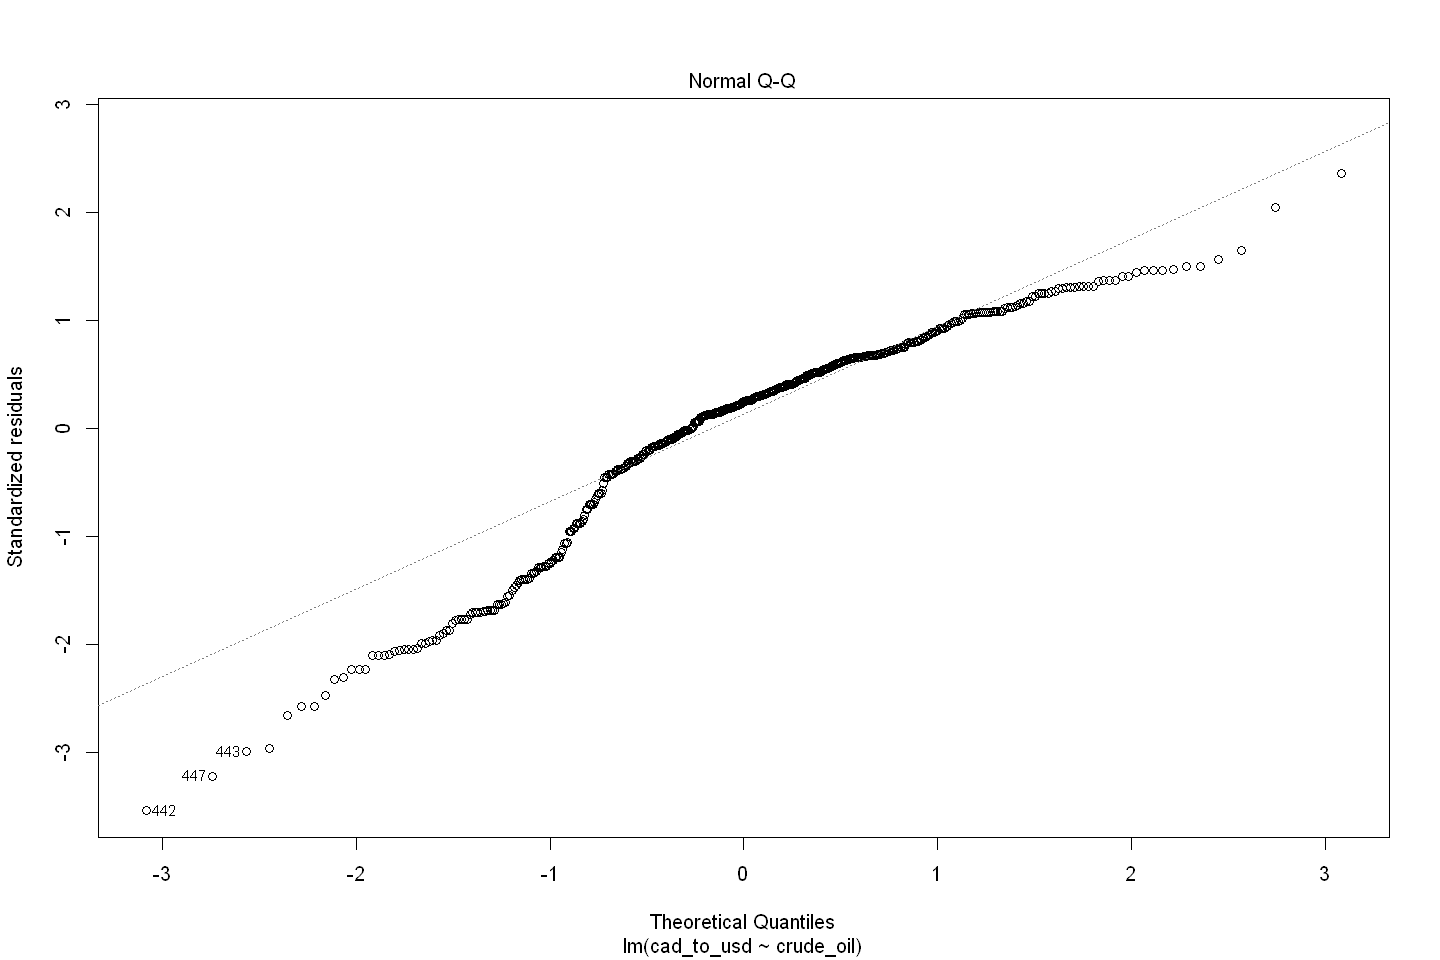

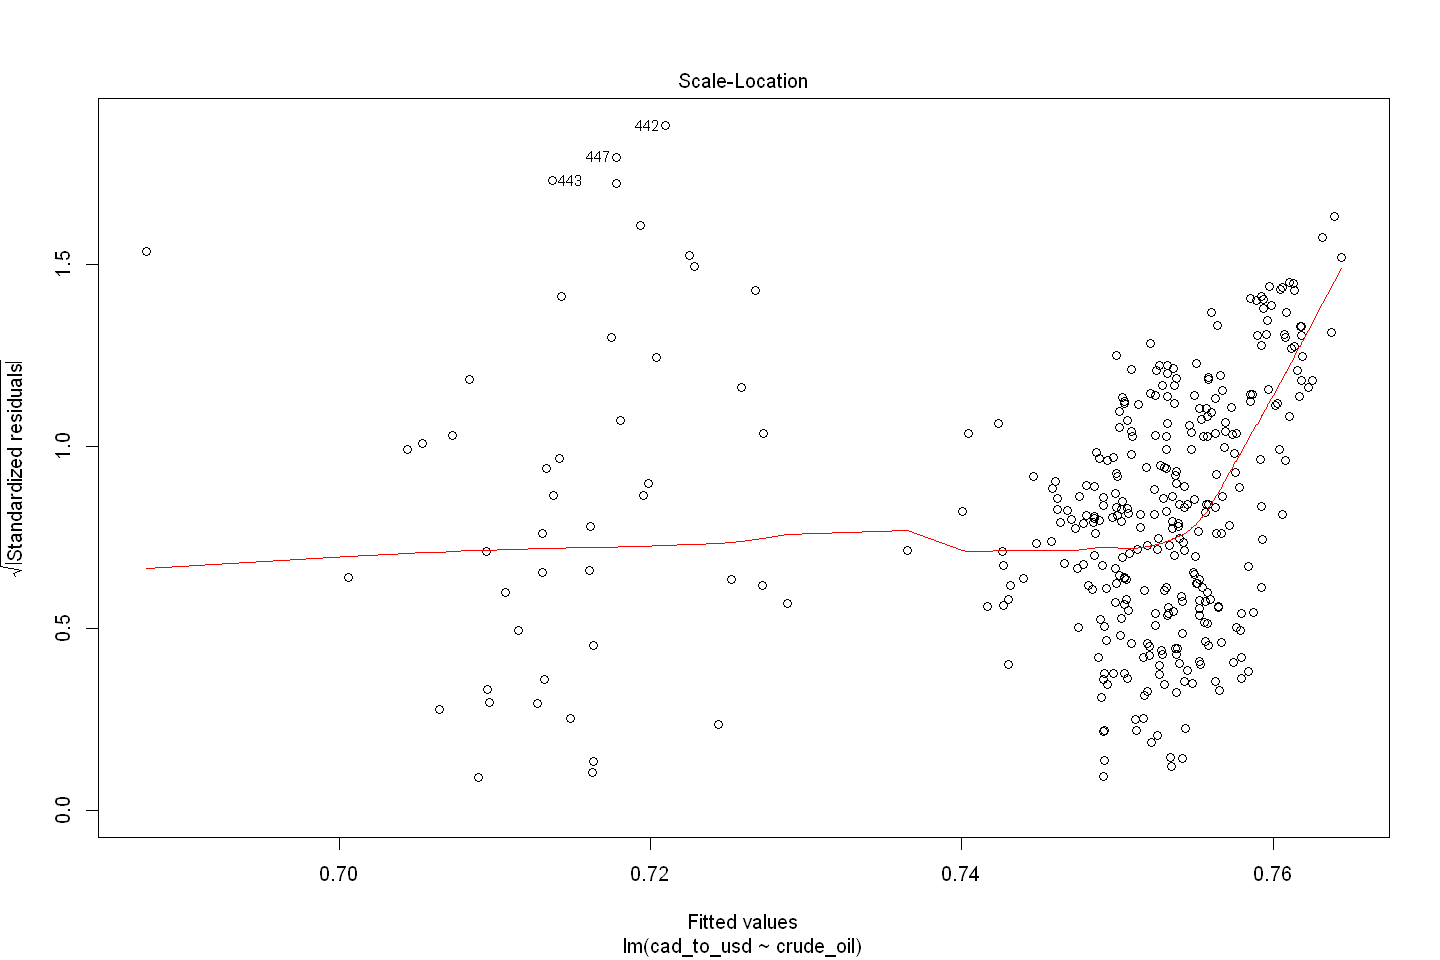

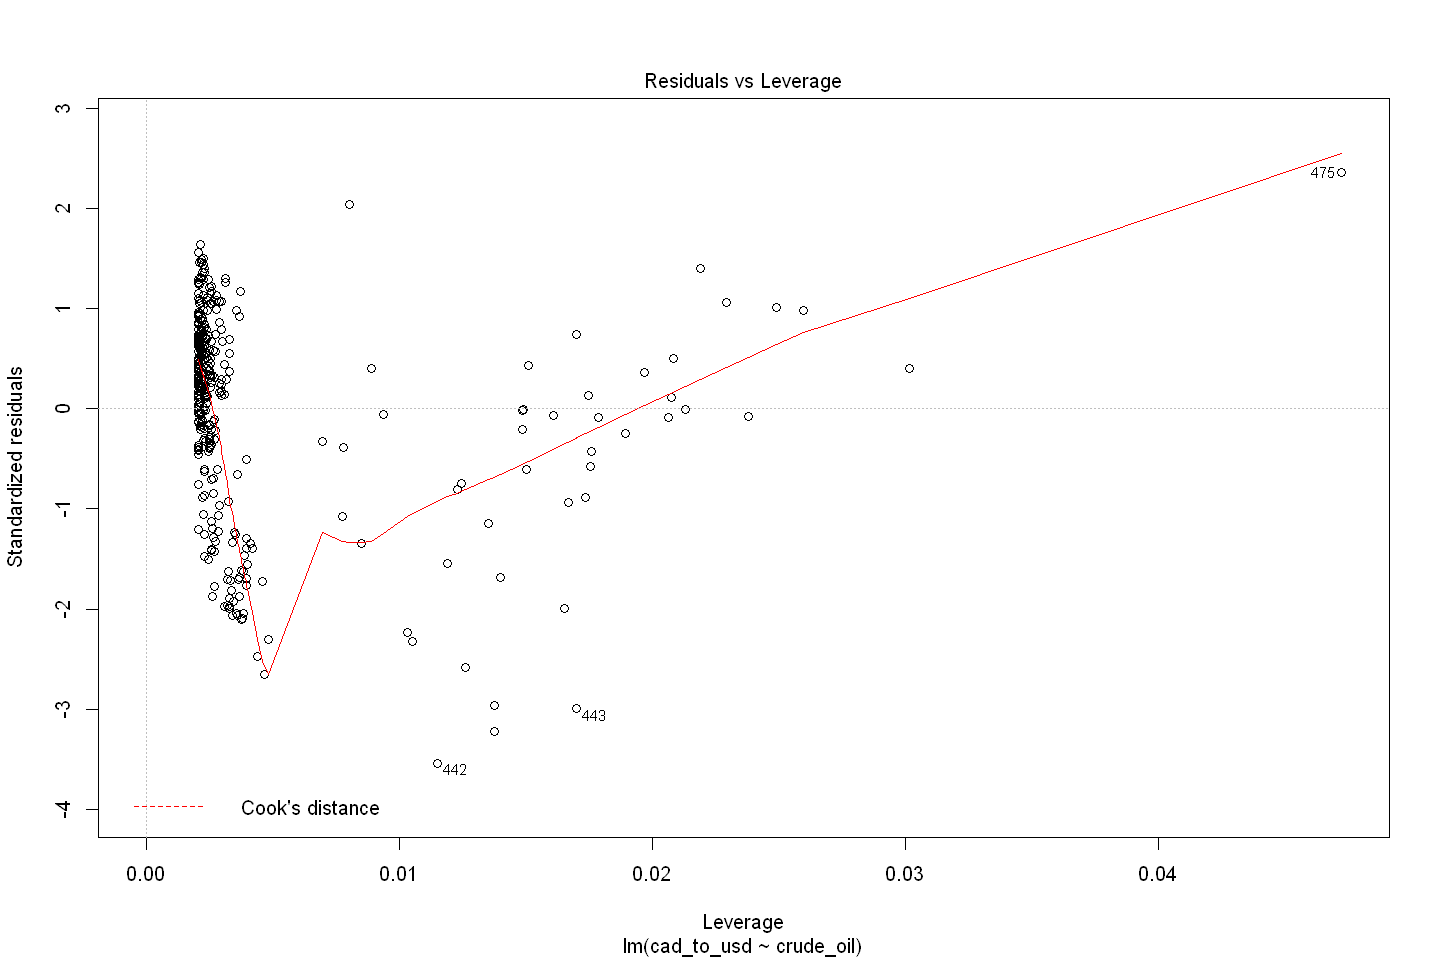

In [402]:
fit <- lm(cad_to_usd ~ crude_oil, data_cp%>% filter(date > as.Date("2019-1-1")))
summary(fit)
plot(fit)


Call:
glm(formula = cad_to_usd ~ crude_oil, family = Gamma, data = data_cp %>% 
    filter(date > as.Date("2019-1-1")))

Deviance Residuals: 
      Min         1Q     Median         3Q        Max  
-0.042745  -0.004743   0.002682   0.007947   0.025185  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.444e+00  3.393e-03  425.53   <2e-16 ***
crude_oil   -2.062e-03  6.261e-05  -32.94   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Gamma family taken to be 0.0001375962)

    Null deviance: 0.22038  on 487  degrees of freedom
Residual deviance: 0.06736  on 486  degrees of freedom
AIC: -3228.6

Number of Fisher Scoring iterations: 3


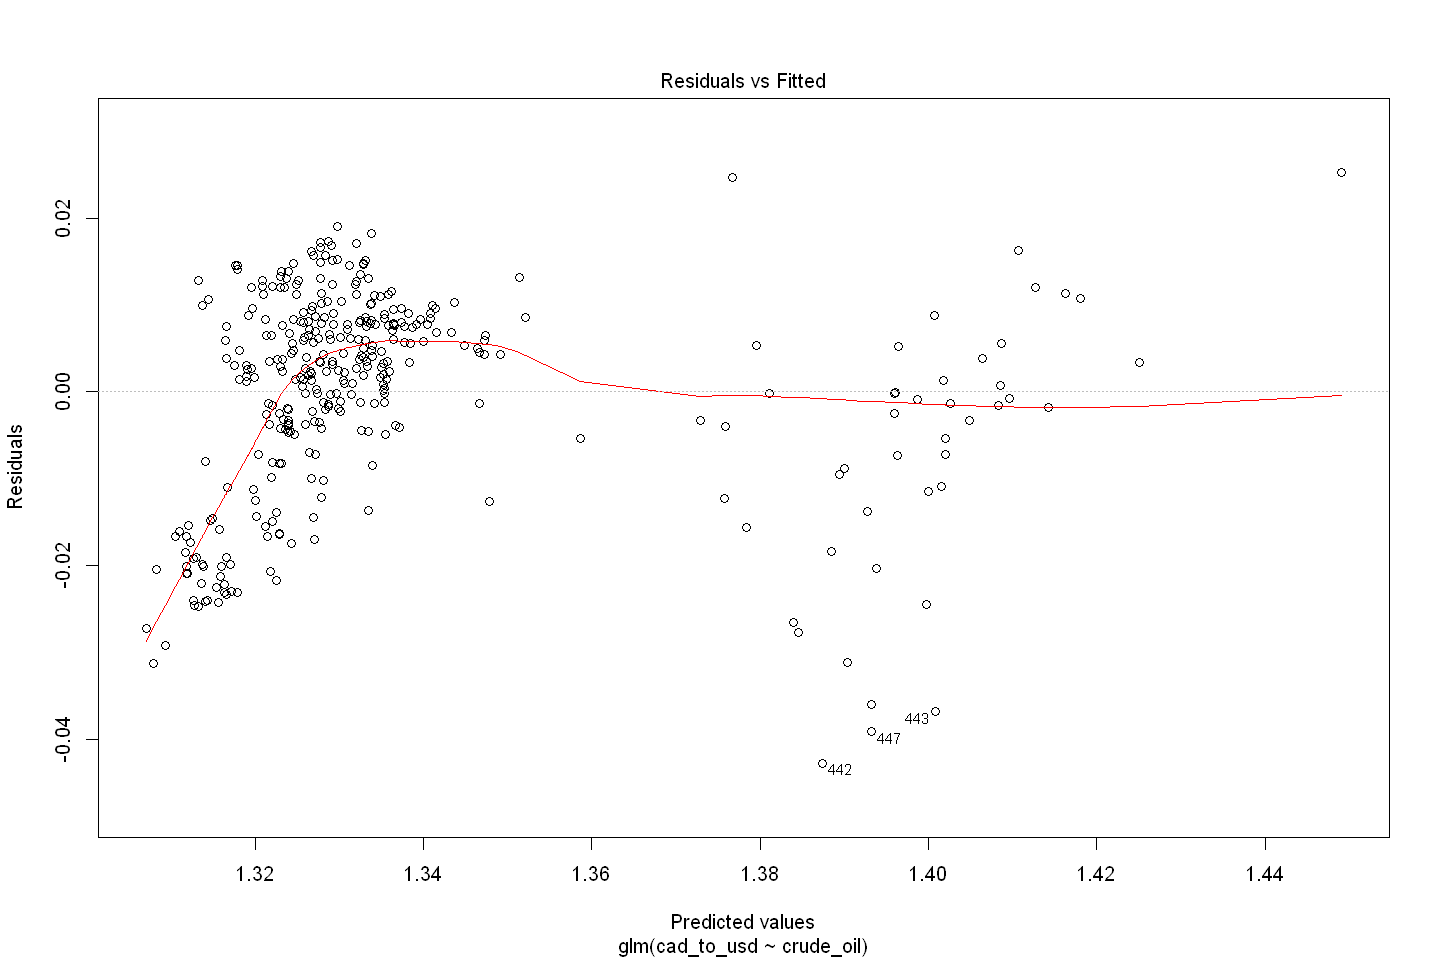

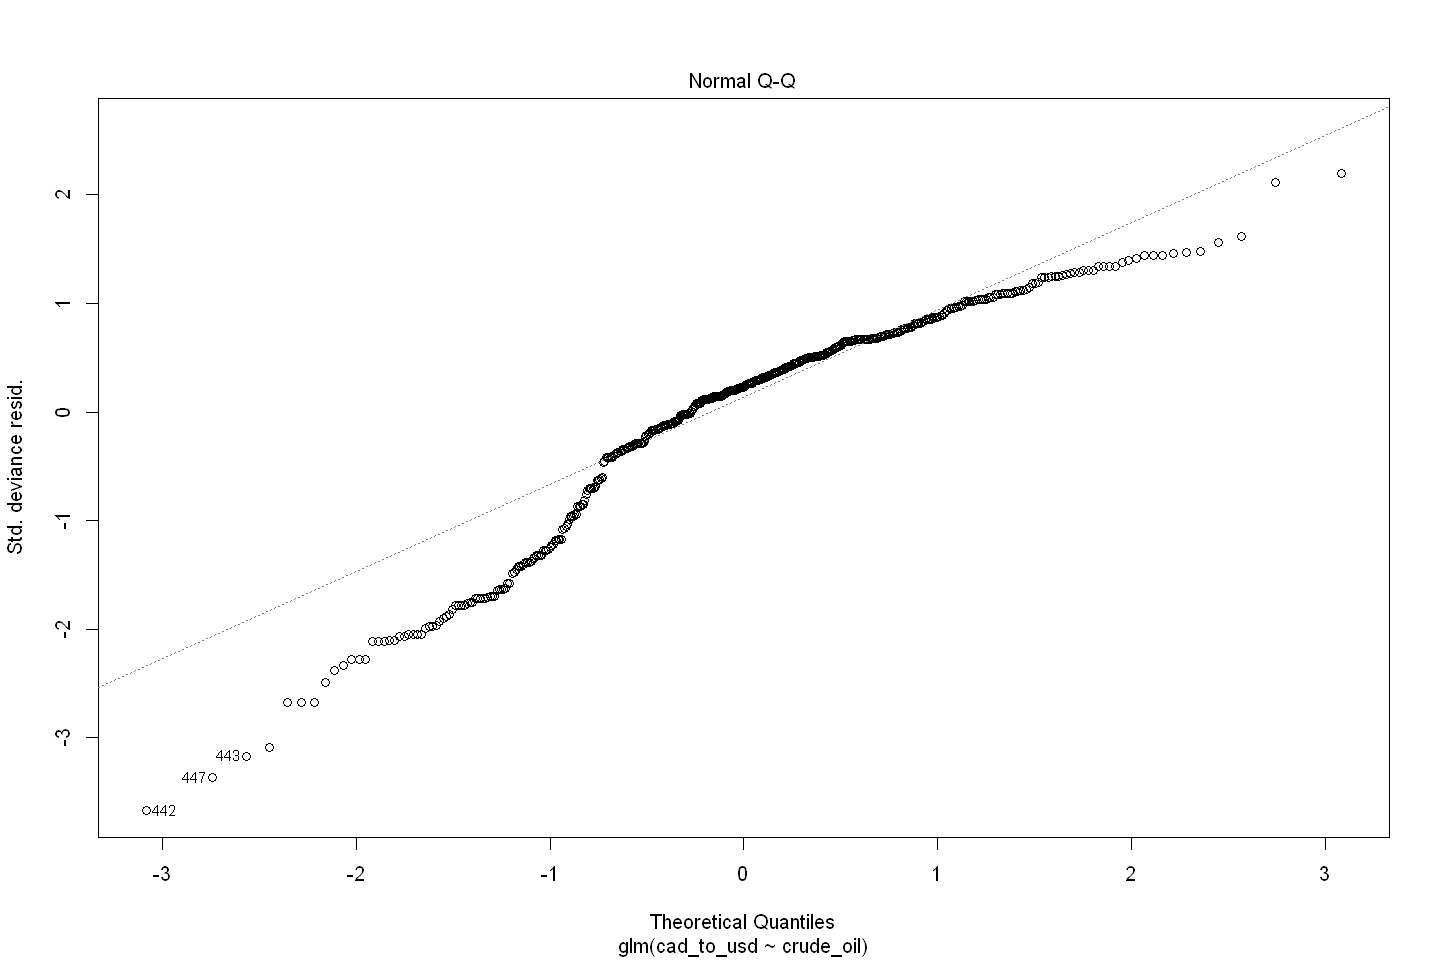

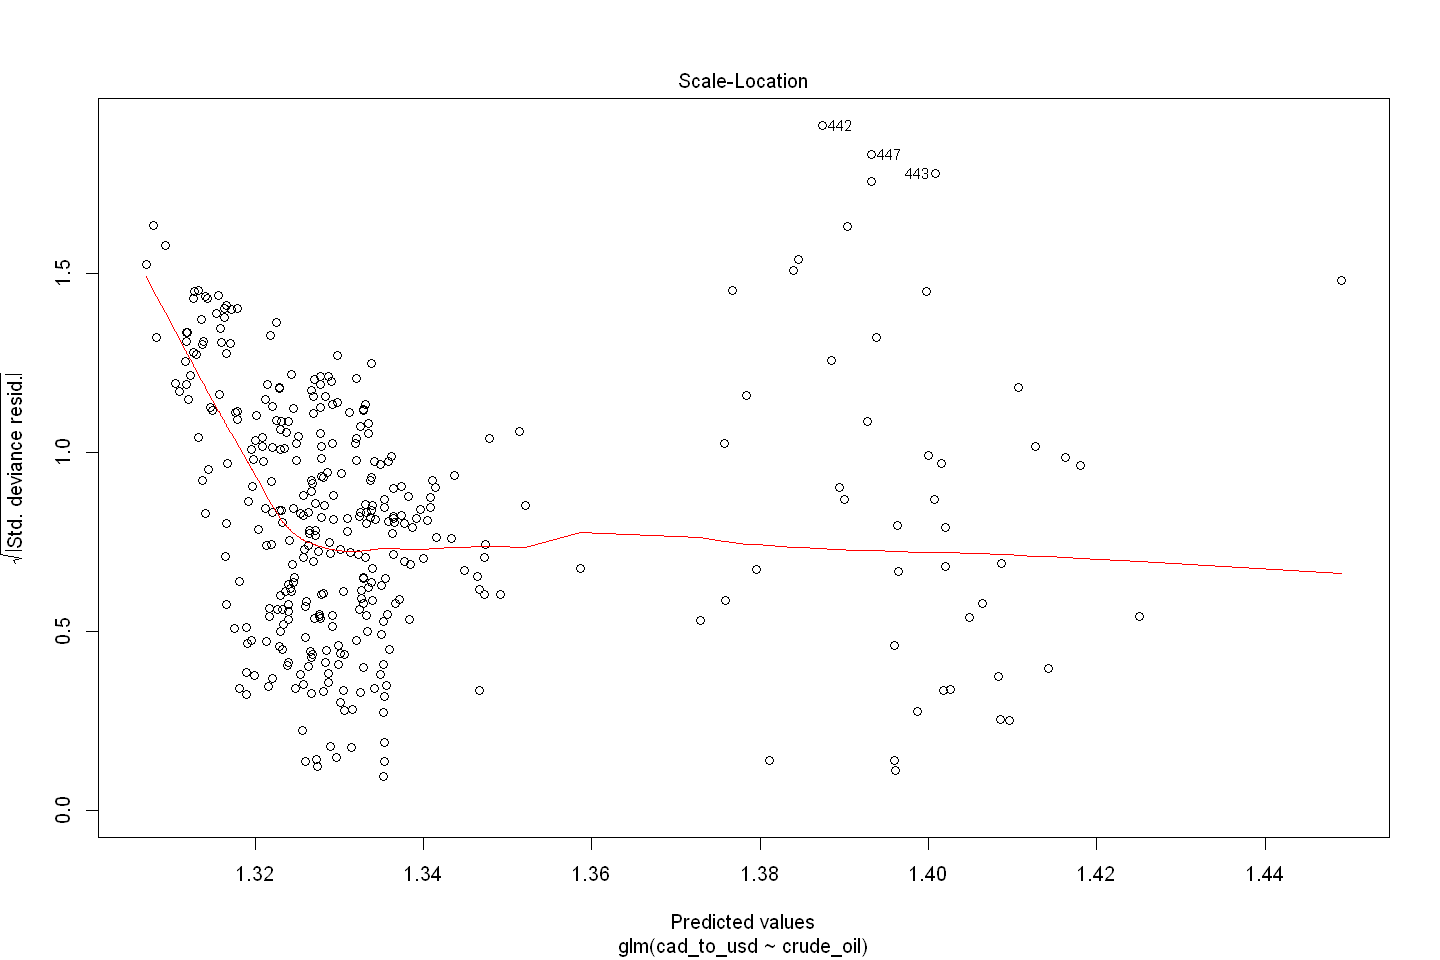

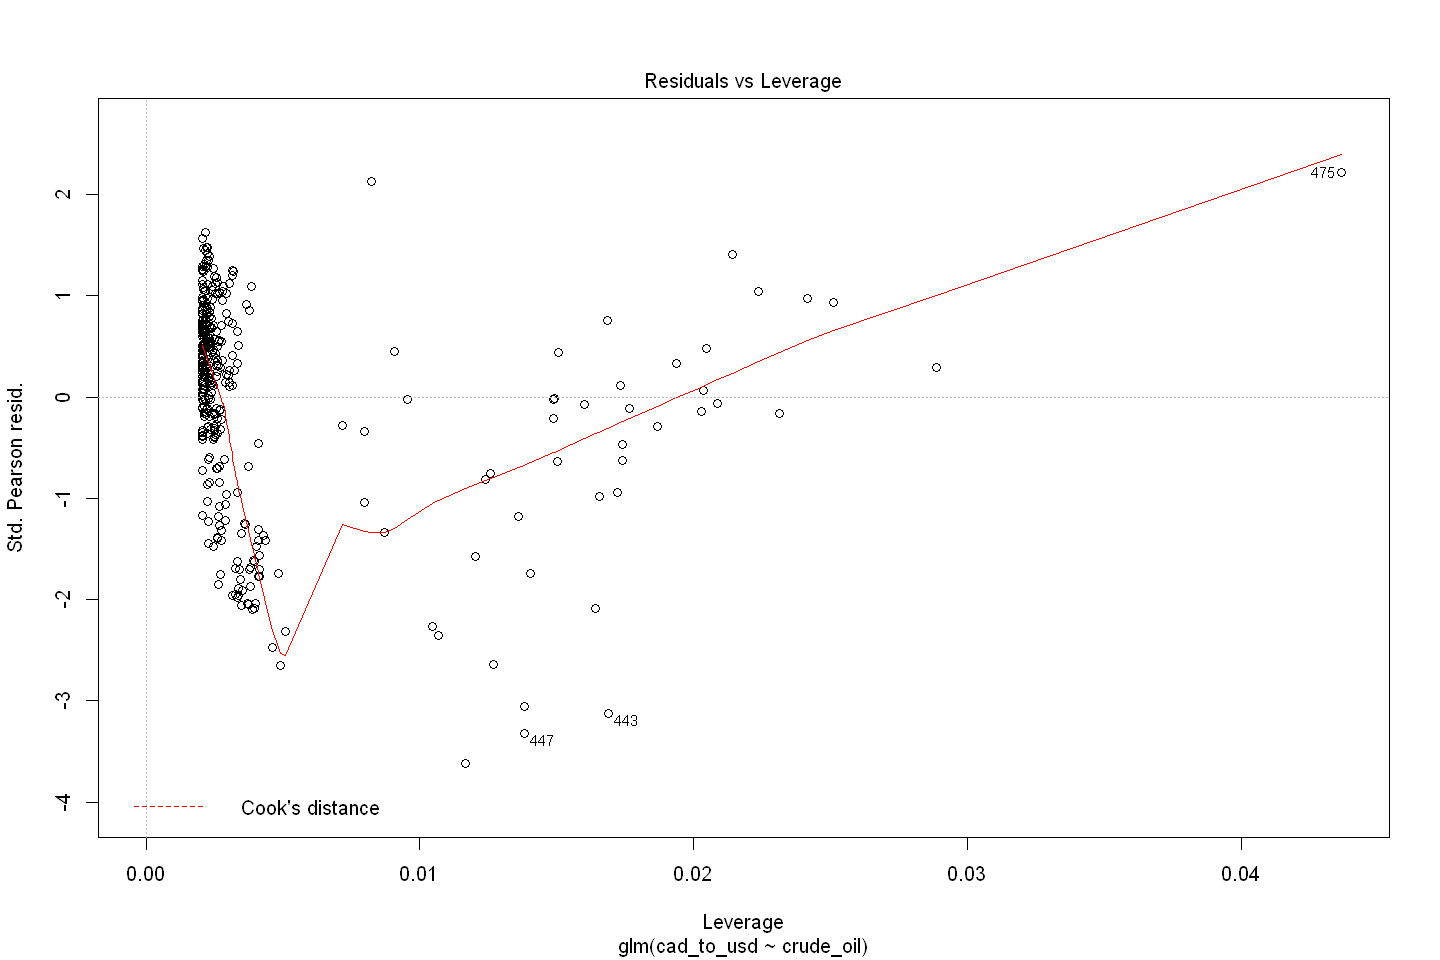

In [401]:
fit <- glm(cad_to_usd ~ crude_oil, data_cp%>% filter(date > as.Date("2019-1-1")), family = Gamma)
summary(fit)
plot(fit)


Call:
forecast::tslm(formula = cad_to_usd_ts ~ crude_oil_ts)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.029681 -0.006879 -0.000949  0.004350  0.045981 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.855e-01  2.269e-03  302.09   <2e-16 ***
crude_oil_ts 1.264e-03  3.847e-05   32.86   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.01307 on 851 degrees of freedom
Multiple R-squared:  0.5593,	Adjusted R-squared:  0.5587 
F-statistic:  1080 on 1 and 851 DF,  p-value: < 2.2e-16


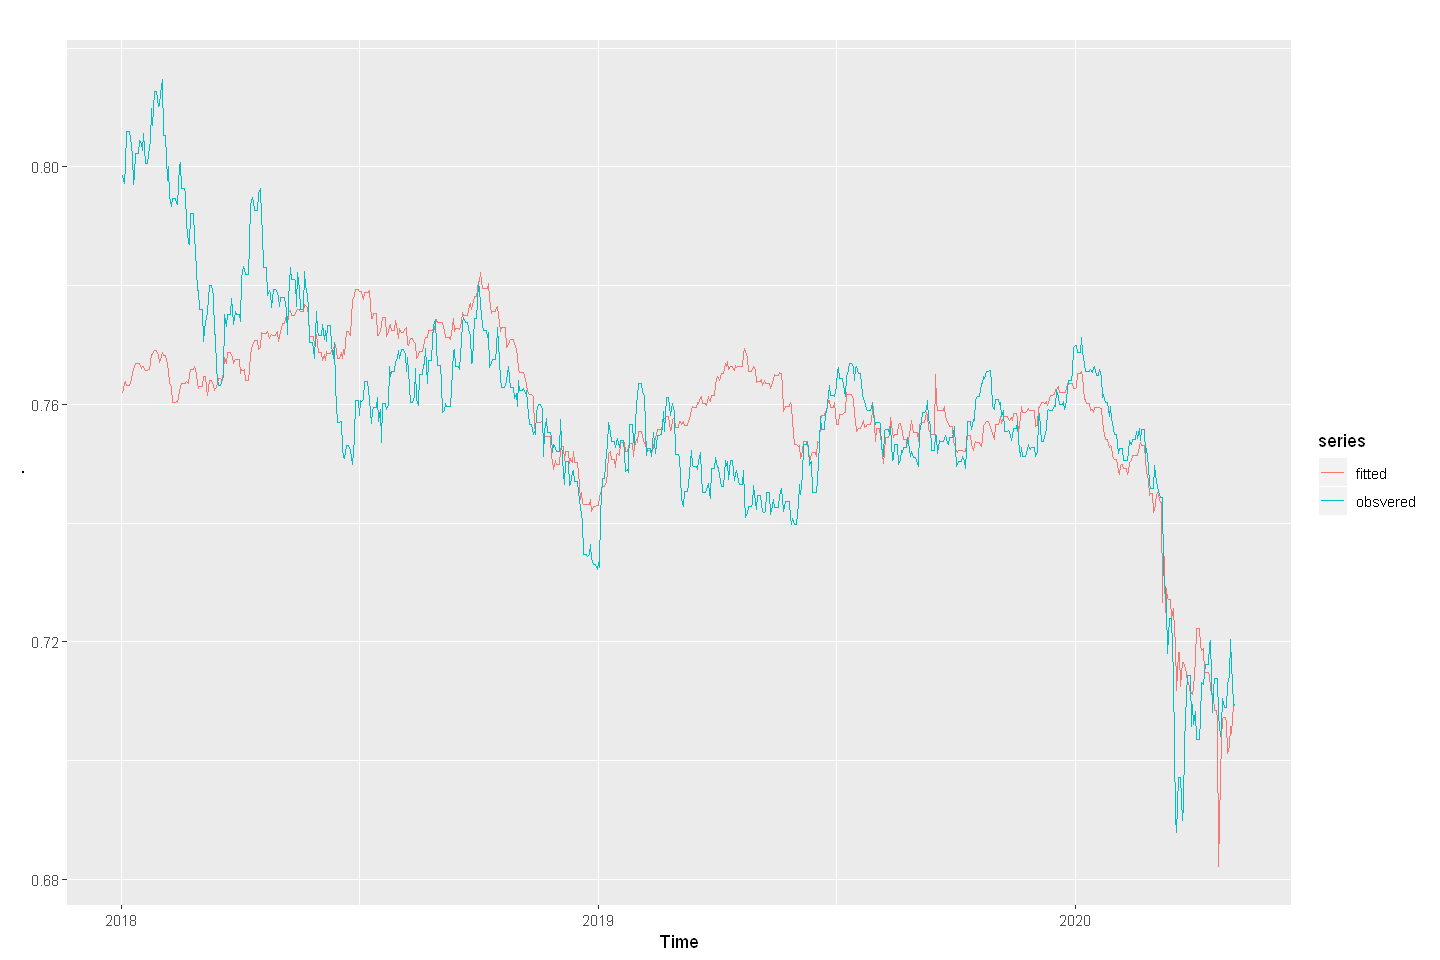

In [333]:
fit <- forecast::tslm(cad_to_usd_ts ~ crude_oil_ts)
summary(fit)
fit$fitted %>%
    autoplot(series = "fitted") +
    autolayer(cad_to_usd_ts, series = "obsvered")

## 8. Summary and conclusions
